In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
#import the Amazon Fine Food Review dataset
import zipfile
import pandas as pd

# Path to the zip file in the session storage
zip_file_path = '/content/Reviews.csv.zip'

# Directory to extract the files
extracted_dir_path = '/content'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# List the extracted files (assuming there's only one CSV file)
extracted_files = zip_ref.namelist()

# Load the CSV file into a DataFrame
if len(extracted_files) > 0:
    csv_file_path = extracted_dir_path + '/' + extracted_files[0]
    data = pd.read_csv(csv_file_path, nrows=100000)
    print("DataFrame created successfully.")
else:
    print("No CSV files found in the extracted directory.")
data.shape

DataFrame created successfully.


(100000, 10)

In [ ]:
print(data.isnull().sum())

Id                        0
ProductId                 0
UserId                    0
ProfileName               6
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64


In [ ]:
# Drop any duplicate and null values present
data.drop_duplicates(subset=['Text'],inplace=True)  # To have diverse range of unique text
data.dropna(axis=0,inplace=True)

In [ ]:
# Map common English contractions to their expanded forms, ensuring that the vocabulary is consistent and that the model understands the full meaning of contractions in text data.
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    # Converting text to lowercase to ensure uniformity.
    newString = text.lower()
    # Removing HTML tags using BeautifulSoup.
    newString = BeautifulSoup(newString, "lxml").text
    # Removing punctuation and special characters.
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    # Expanding contractions
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    # Removing possessive forms (e.g., "'s").
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                      #removing short word
            long_words.append(i)
    # Lastly, return the processed text
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Call the text_cleaner function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [ ]:
# Printing 5 cleaned reviews
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [ ]:
# Call the text_cleaner function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [ ]:
# Printing 10 cleaned original summaries
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [ ]:
# Add cleaned_text and cleaned_summary to the data frame
data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

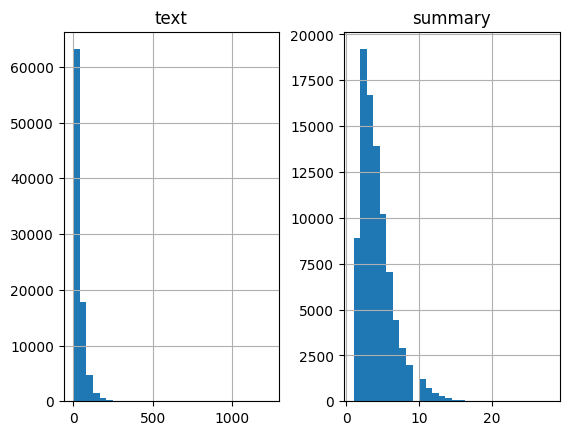

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9424894452681977


In [ ]:
max_text_len=30
max_summary_len=8

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.07775273663876
Total Coverage of rare words: 2.94478384433473


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

8430

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.2646994054173
Total Coverage of rare words: 5.413717749260335


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
class AttentionLayer(Layer):


    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)

        """
        There are three sets of weights introduced W_a, U_a, and V_a.
        W_a: Weight matrix for ENCODER OUTPUTS.
        U_a: Weight matrix for DECODDER OUTPUTS.
        V_a: Weight matrix for computing ATTENTION SCORES.
        All 3 are uniformly initialized & trainable.
        """

        """
        Encoder output sequence has a shape of (batch_size, encoder_seq_length, encoder_hidden_dim)
        W_a has shape: (encoder_hidden_dim, encoder_hidden_dim)
        Its shape is determined by the dimensionality of the encoder output hidden states.
        So this weight matrix connects the encoder output sequence to itself.

        FUNCTION: This weight matrix captures the relationship between different time steps in the encoder output sequence. It helps determine how much attention to give to each encoder hidden state.
        """
        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)

        """
        The decoder output sequence has a shape of (batch_size, decoder_seq_length, decoder_hidden_dim).
        U_a shape: (decoder_hidden_dim, encoder_hidden_dim).
        Its shape is determined by the dimensionality of the decoder and encoder output hidden states.
        This weight matrix connects the decoder output sequence to the encoder output sequence.

        FUNCTION: Determines how much influence each decoder hidden state should have on the attention mechanism. It helps align the decoder's focus with relevant parts of the input sequence.
        """
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)

        """
        V_a shape: (encoder_hidden_dim, 1).
        Its shape is determined by the dimensionality of the encoder output hidden states.
        This weight matrix is used to compute the attention scores.

        FUNCTION: The V_a matrix calculates the attention scores for each encoder hidden state. It helps weigh the importance of different encoder states when generating the context vector.
        """
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        # Finally call this build method
        super(AttentionLayer, self).build(input_shape)

    # Method defines: behavior of the layer when it's called during the forward pass of the model.
    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """

        assert type(inputs) == list     # check if 'inputs' is a list.

        # Unpack the inputs list into 2 variables: 1] encoder_out_seq & 2] decoder_out_seq
        encoder_out_seq, decoder_out_seq = inputs

        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        # Method computes the attention energy for a single decoder state.
        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            #  Check if the states variable is of type list or tuple. If not, it raises an assertion error with the constructed message.
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """
            Unpack the shape of the 'encoder_out_seq' into 2 variables :
            1] en_seq_len (encoder sequence length)
            2] en_hidden (encoder hidden state dimension).
            """
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]

            """
            Extract the last dimension of decoder hidden dimension ans store that value in de_hidden.
            """
            de_hidden = inputs.shape[-1]

            """
            Compute the dot product of the encoder output sequence (encoder_out_seq) and the weight matrix W_a.
            W_a_dot_s represents: the attentional energy distribution over the encoder sequence.
            W_a_dot_s shape : batch size , en_seq_len , latent_dim
            """
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """
            Compute the dot product of the decoder state (inputs) and the weight matrix U_a.
            Then add a new dimension at axis 1 using K.expand_dims.
            After this operation, the shape of U_a_dot_h becomes (batch_size , 1 , latent_dim).
            This is done to match the shape of Ws_plus_Uh for further computation.
            """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """
            Compute the element-wise hyperbolic tangent of the sum of W_a_dot_s and U_a_dot_h.
            Ws_plus_Uh shape : (batch_size , en_seq_len , latent_dim).
            """
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """
            Perform dot product between Ws_plus_Uh and the weight matrix V_a(attention scores for each encoder hidden state)
            shape : (batch_size , en_seq_len , 1)
            K.squeeze operation is used to remove the singleton dimension.
            shape : (batch_size , en_seq_len)
            """
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)

            """
            Compute the softmax activation of e_i, resulting in attention scores for each token in the encoder sequence.
            shape : (batch_size, en_seq_len)
            """
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            # Finally return the attention scores and list of attention scores e_i.
            return e_i, [e_i]

        # This function represents a step in the calculation of context vectors c_i using attention scores e_i.
        def context_step(inputs, states):

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """
            1] Compute the context vector 'c_i' using the attention scores 'inputs' and the encoder output sequence encoder_out_seq (expand the dimensions of the inputs(e_i) tensor to match the dimensions of the encoder output sequence)
            2] Perform element-wise multiplication between the encoder output sequence and the expanded attention scores, effectively applying attention.
            3] Them sum the encoder_out_seq and e_i along the time axis.
            """
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        """
        Compute a fake state 'fake_state_c' by summing the encoder output sequence along the time axis. This fake state is used as the initial state for the K.rnn function.
        """
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from keras import backend as K
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              843000    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 30, 300),            481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/50
323/323 [==============================] - 170s 467ms/step - loss: 2.8989 - val_loss: 2.5875
Epoch 2/50
323/323 [==============================] - 140s 433ms/step - loss: 2.5611 - val_loss: 2.4678
Epoch 3/50
323/323 [==============================] - 123s 380ms/step - loss: 2.4423 - val_loss: 2.3816
Epoch 4/50
323/323 [==============================] - 146s 451ms/step - loss: 2.3367 - val_loss: 2.2800
Epoch 5/50
323/323 [==============================] - 135s 416ms/step - loss: 2.2271 - val_loss: 2.1936
Epoch 6/50
323/323 [==============================] - 116s 360ms/step - loss: 2.1285 - val_loss: 2.1365
Epoch 7/50
323/323 [==============================] - 114s 353ms/step - loss: 2.0485 - val_loss: 2.1019
Epoch 8/50
323/323 [==============================] - 122s 377ms/step - loss: 1.9781 - val_loss: 2.0661
Epoch 9/50
323/323 [==============================] - 112s 348ms/step - loss: 1.9124 - val_loss: 2.0512
Epoch 10/50
323/323 [==============================] - 131s 406m

In [ ]:
model.save('trained_model.h5')

In [ ]:
model.save('model.py')

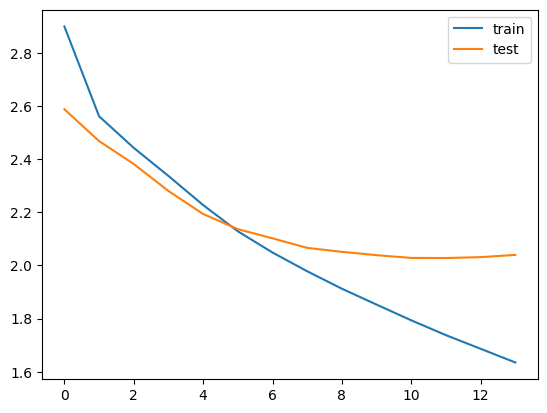

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,50):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: daughter used quaker instant oatmeal liked lot long time ago tried version like fact want finish sure maybe lots new ingredients artificial 
Original summary: not very good 
1/1 [==============================] - 0s 30ms/step
Predicted summary:  good but not great


Review: liked coffee much subscribing dark rich smooth 
Original summary: makes great cup of java 
1/1 [==============================] - 0s 20ms/step
Predicted summary:  great coffee


Review: like fool ordered box instead bag try disgusting smell like dead fish rinsed rinsed still smelled right light even look purple crack cannot believe stupid buy 
Original summary: gross 
1/1 [==============================] - 0s 19ms/step
Predicted summary:  gross


Review: flavorful packaged soup long time nice spicy taste good blend herbs cannot wait becomes available stores 
Original summary: delicious treat 
1/1 [==============================] - 0s 19ms/step
Predicted summary:  great soup


Review: taste like pop refreshin

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge

def calculate_rouge_scores(reference, hypothesis):
    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference, avg=True)
    return scores

# Example usage
reference = "Reference summary"  # Original summary
hypothesis = "Predicted summary"  # Predicted summary
rouge_scores = calculate_rouge_scores(reference, hypothesis)

# Print ROUGE scores
print("ROUGE scores:")
for metric, scores in rouge_scores.items():
    print(f"  {metric}:")
    print(f"    Recall:    {scores['r']:.2f}")
    print(f"    Precision: {scores['p']:.2f}")
    print(f"    F1-score:  {scores['f']:.2f}")


ROUGE scores:
  rouge-1:
    Recall:    0.50
    Precision: 0.50
    F1-score:  0.50
  rouge-2:
    Recall:    0.00
    Precision: 0.00
    F1-score:  0.00
  rouge-l:
    Recall:    0.50
    Precision: 0.50
    F1-score:  0.50


In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
!jupyter nbconvert --to pdf /content/DL_PBL_2.ipynb